# Análisis Watchlists E0 (PASO 3)

Análisis comprehensivo de watchlists E0 generados:
- Evolución temporal de eventos E0
- Distribución de métricas (% cambio, RVOL, dollar volume)
- Tickers más activos
- Estadísticas globales

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Tamaño de figuras por defecto
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Cargar watchlists
project_root = Path(r"D:\04_TRADING_SMALLCAPS")
watchlist_dir = project_root / "processed" / "universe" / "info_rich" / "daily"

# Listar todos los watchlists
watchlist_files = list(watchlist_dir.glob("date=*/watchlist.parquet"))
print(f"Total watchlists encontrados: {len(watchlist_files):,}")

# Cargar todos en un DataFrame
all_watchlists = []
for wl_file in watchlist_files:
    date = wl_file.parent.name.replace('date=', '')
    df = pl.read_parquet(wl_file)
    df = df.with_columns(pl.lit(date).alias('watchlist_date'))
    all_watchlists.append(df)

df_all = pl.concat(all_watchlists)
print(f"✓ Total eventos E0: {len(df_all):,}")
print(f"✓ DataFrame shape: {df_all.shape}")
print(f"✓ Columnas: {df_all.columns}")

Total watchlists encontrados: 5,934


✓ Total eventos E0: 8,696,865
✓ DataFrame shape: (8696865, 15)
✓ Columnas: ['ticker', 'trading_day', 'close_d', 'pctchg_d', 'rvol30', 'vol_d', 'dollar_vol_d', 'vwap_d', 'market_cap_d', 'r_rvol', 'r_chg', 'r_dvol', 'r_px', 'info_rich', 'watchlist_date']


---
## 1. ANÁLISIS TEMPORAL

In [3]:
# Agrupar por fecha
daily_stats = (df_all
    .group_by('watchlist_date')
    .agg([
        pl.count('ticker').alias('tickers_e0'),
        pl.col('pctchg_d').mean().alias('avg_pctchg'),
        pl.col('rvol30').mean().alias('avg_rvol'),
        pl.col('dollar_vol_d').mean().alias('avg_dollar_vol')
    ])
    .sort('watchlist_date')
)

# Convertir a pandas para plotting
df_daily = daily_stats.to_pandas()
df_daily['watchlist_date'] = pd.to_datetime(df_daily['watchlist_date'])

print(f"Días con eventos E0: {len(df_daily):,}")

Días con eventos E0: 5,934


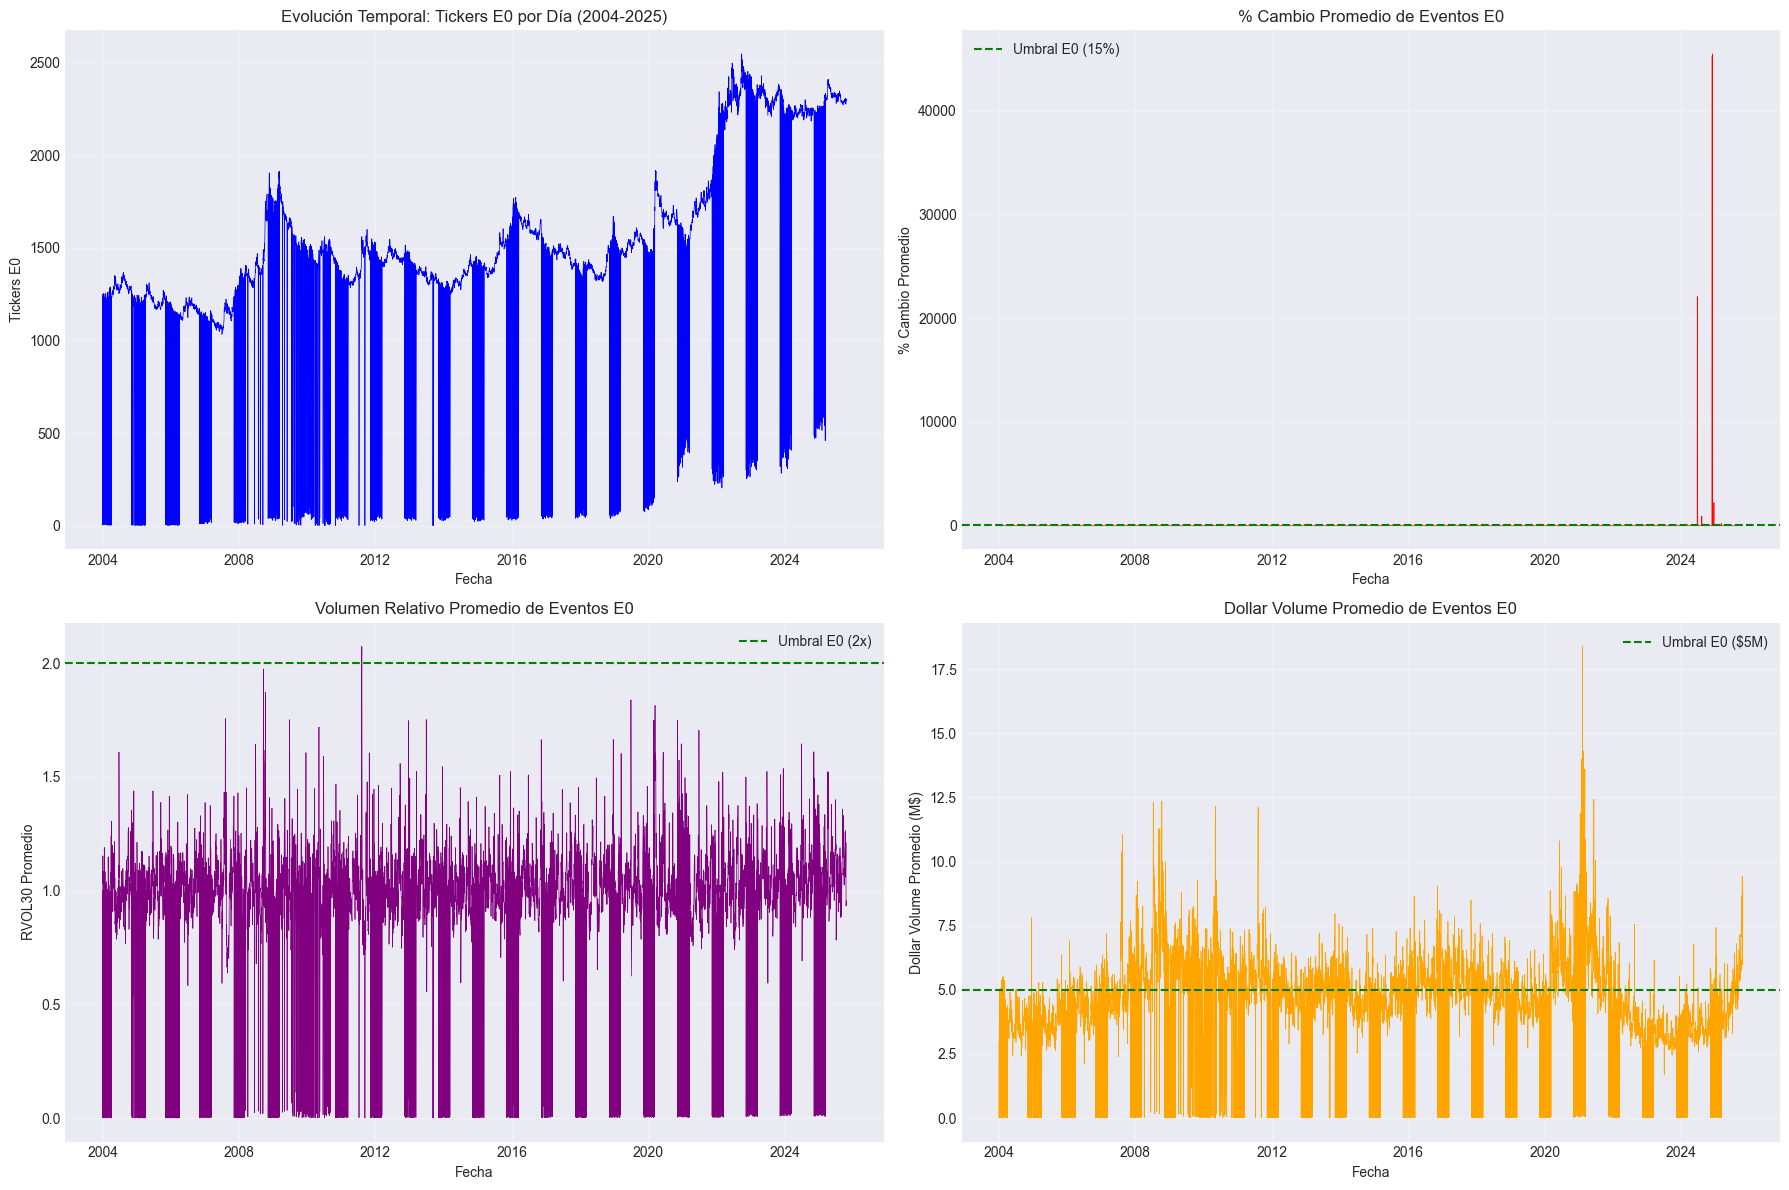


ESTADÍSTICAS TEMPORALES
Días con eventos E0: 5,934
Promedio eventos E0/día: 1465.6
Mediana eventos E0/día: 1450
Máximo eventos E0/día: 2546 (2022-09-26)


In [4]:
# GRÁFICA 1: Evolución temporal de eventos E0
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1.1 Tickers E0 por día
axes[0, 0].plot(df_daily['watchlist_date'], df_daily['tickers_e0'], linewidth=0.5, color='blue')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Tickers E0')
axes[0, 0].set_title('Evolución Temporal: Tickers E0 por Día (2004-2025)')
axes[0, 0].grid(True, alpha=0.3)

# 1.2 % Cambio promedio
axes[0, 1].plot(df_daily['watchlist_date'], df_daily['avg_pctchg'] * 100, linewidth=0.5, color='red')
axes[0, 1].axhline(y=15, color='green', linestyle='--', label='Umbral E0 (15%)')
axes[0, 1].set_xlabel('Fecha')
axes[0, 1].set_ylabel('% Cambio Promedio')
axes[0, 1].set_title('% Cambio Promedio de Eventos E0')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 1.3 RVOL promedio
axes[1, 0].plot(df_daily['watchlist_date'], df_daily['avg_rvol'], linewidth=0.5, color='purple')
axes[1, 0].axhline(y=2.0, color='green', linestyle='--', label='Umbral E0 (2x)')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('RVOL30 Promedio')
axes[1, 0].set_title('Volumen Relativo Promedio de Eventos E0')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 1.4 Dollar Volume promedio
axes[1, 1].plot(df_daily['watchlist_date'], df_daily['avg_dollar_vol'] / 1e6, linewidth=0.5, color='orange')
axes[1, 1].axhline(y=5, color='green', linestyle='--', label='Umbral E0 ($5M)')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].set_ylabel('Dollar Volume Promedio (M$)')
axes[1, 1].set_title('Dollar Volume Promedio de Eventos E0')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas temporales
print("\n" + "="*80)
print("ESTADÍSTICAS TEMPORALES")
print("="*80)
print(f"Días con eventos E0: {len(df_daily):,}")
print(f"Promedio eventos E0/día: {df_daily['tickers_e0'].mean():.1f}")
print(f"Mediana eventos E0/día: {df_daily['tickers_e0'].median():.0f}")
print(f"Máximo eventos E0/día: {df_daily['tickers_e0'].max():.0f} ({df_daily.loc[df_daily['tickers_e0'].idxmax(), 'watchlist_date'].date()})")

---
## 2. DISTRIBUCIÓN DE EVENTOS E0

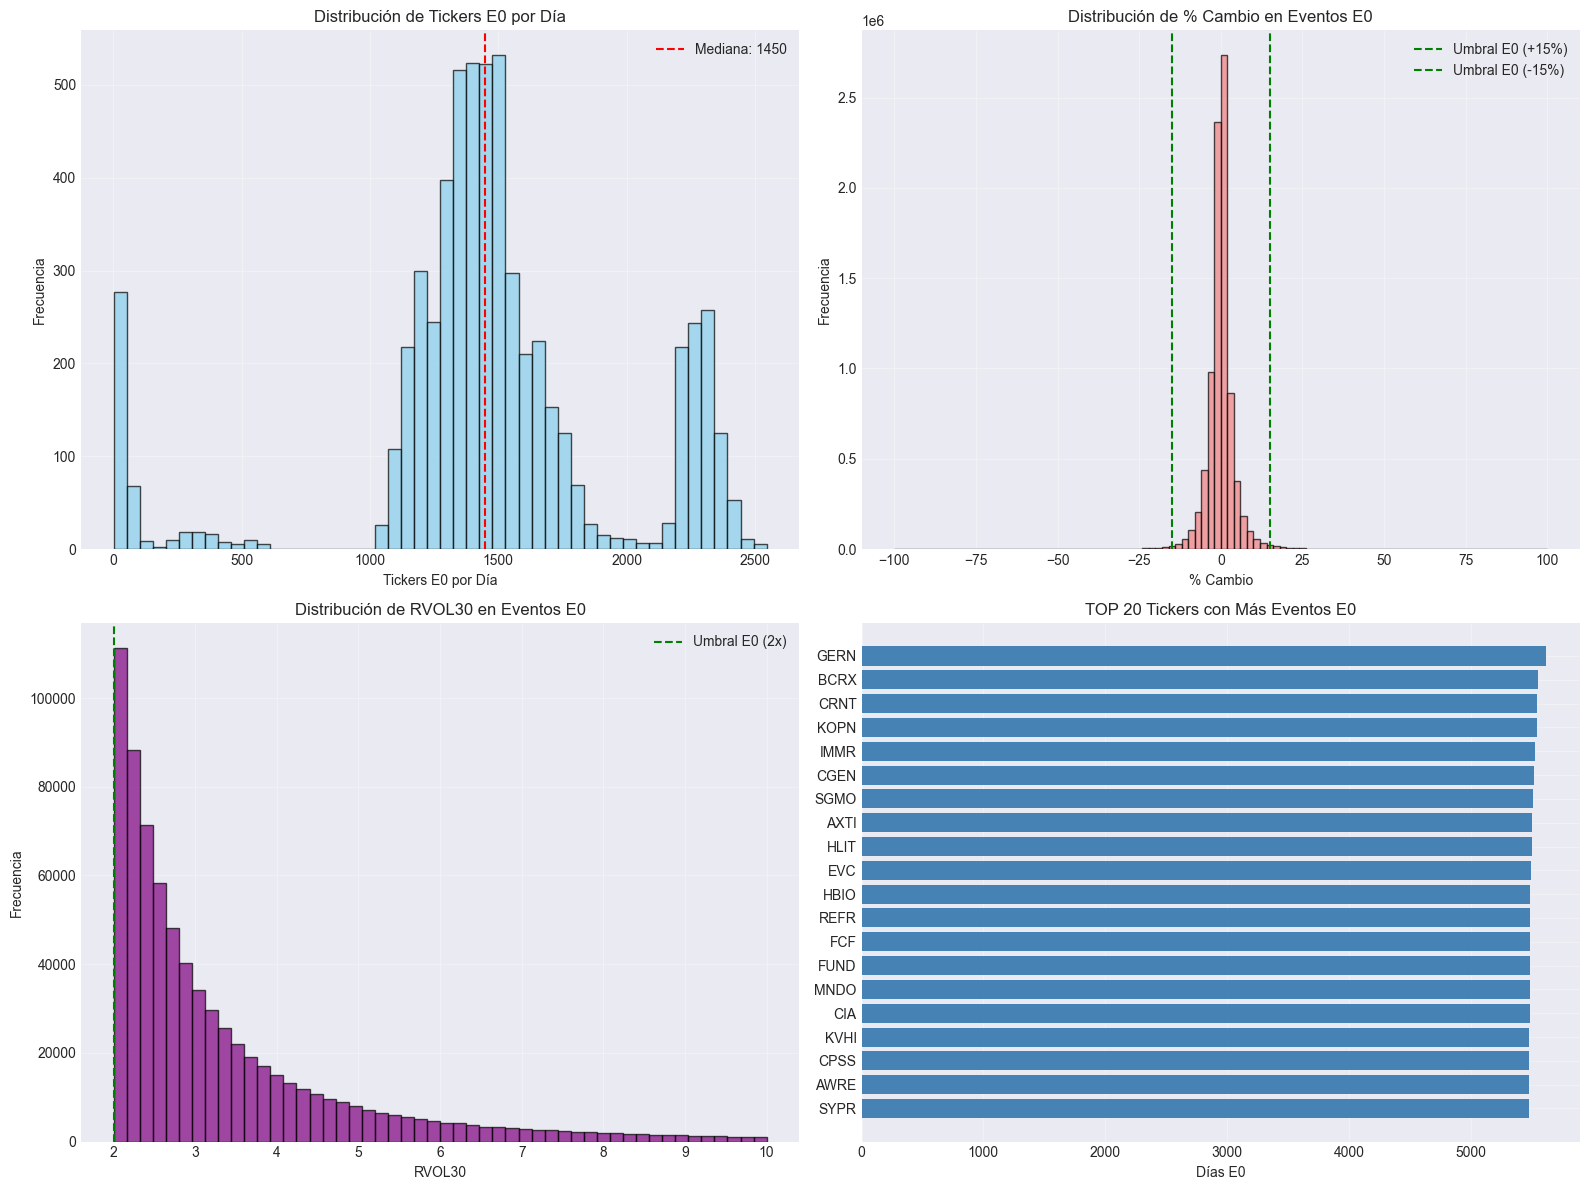


DISTRIBUCIÓN DE MÉTRICAS

% CAMBIO:
  Promedio: 29.68%
  Mediana: 0.00%
  Std: 50686.03%

RVOL30:
  Promedio: 1.04x
  Mediana: 0.76x
  Std: 1.37x

DOLLAR VOLUME:
  Promedio: $4,958,372
  Mediana: $542,743


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2.1 Distribución de tickers E0 por día
axes[0, 0].hist(df_daily['tickers_e0'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Tickers E0 por Día')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Tickers E0 por Día')
axes[0, 0].axvline(df_daily['tickers_e0'].median(), color='red', linestyle='--',
                   label=f'Mediana: {df_daily["tickers_e0"].median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2.2 Distribución de % cambio en eventos E0
pctchg_data = df_all['pctchg_d'].to_numpy() * 100
axes[0, 1].hist(pctchg_data, bins=100, color='lightcoral',
                edgecolor='black', alpha=0.7, range=(-100, 100))
axes[0, 1].set_xlabel('% Cambio')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de % Cambio en Eventos E0')
axes[0, 1].axvline(x=15, color='green', linestyle='--', label='Umbral E0 (+15%)')
axes[0, 1].axvline(x=-15, color='green', linestyle='--', label='Umbral E0 (-15%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 2.3 Distribución de RVOL30
rvol_data = df_all['rvol30'].to_numpy()
axes[1, 0].hist(rvol_data, bins=50, color='purple',
                edgecolor='black', alpha=0.7, range=(2, 10))
axes[1, 0].set_xlabel('RVOL30')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de RVOL30 en Eventos E0')
axes[1, 0].axvline(x=2.0, color='green', linestyle='--', label='Umbral E0 (2x)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 2.4 TOP 20 tickers con más eventos E0
top_tickers = (df_all
    .group_by('ticker')
    .agg(pl.count('trading_day').alias('e0_days'))
    .sort('e0_days', descending=True)
    .limit(20)
    .to_pandas()
)

axes[1, 1].barh(range(len(top_tickers)), top_tickers['e0_days'].values, color='steelblue')
axes[1, 1].set_yticks(range(len(top_tickers)))
axes[1, 1].set_yticklabels(top_tickers['ticker'].values)
axes[1, 1].set_xlabel('Días E0')
axes[1, 1].set_title('TOP 20 Tickers con Más Eventos E0')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de distribución
print("\n" + "="*80)
print("DISTRIBUCIÓN DE MÉTRICAS")
print("="*80)
print(f"\n% CAMBIO:")
print(f"  Promedio: {df_all['pctchg_d'].mean() * 100:.2f}%")
print(f"  Mediana: {df_all['pctchg_d'].median() * 100:.2f}%")
print(f"  Std: {df_all['pctchg_d'].std() * 100:.2f}%")
print(f"\nRVOL30:")
print(f"  Promedio: {df_all['rvol30'].mean():.2f}x")
print(f"  Mediana: {df_all['rvol30'].median():.2f}x")
print(f"  Std: {df_all['rvol30'].std():.2f}x")
print(f"\nDOLLAR VOLUME:")
print(f"  Promedio: ${df_all['dollar_vol_d'].mean():,.0f}")
print(f"  Mediana: ${df_all['dollar_vol_d'].median():,.0f}")

---
## 3. RESUMEN EJECUTIVO

In [6]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - WATCHLISTS E0 (2004-2025)")
print("="*80)
print(f"\nTOTAL EVENTOS E0: {len(df_all):,}")
print(f"Días con eventos E0: {len(df_daily):,}")
print(f"Tickers únicos con eventos E0: {df_all['ticker'].n_unique():,}")
print(f"\nDISTRIBUCIÓN:")
print(f"  Promedio eventos E0/día: {df_daily['tickers_e0'].mean():.1f}")
print(f"  Mediana eventos E0/día: {df_daily['tickers_e0'].median():.0f}")
print(f"  Máximo eventos E0/día: {df_daily['tickers_e0'].max():.0f}")
print(f"\nMÉTRICAS PROMEDIO:")
print(f"  % Cambio: {df_all['pctchg_d'].mean() * 100:.2f}%")
print(f"  RVOL30: {df_all['rvol30'].mean():.2f}x")
print(f"  Dollar Volume: ${df_all['dollar_vol_d'].mean():,.0f}")
print("\n" + "="*80)


RESUMEN EJECUTIVO - WATCHLISTS E0 (2004-2025)

TOTAL EVENTOS E0: 8,696,865
Días con eventos E0: 5,934


Tickers únicos con eventos E0: 7,948

DISTRIBUCIÓN:
  Promedio eventos E0/día: 1465.6
  Mediana eventos E0/día: 1450
  Máximo eventos E0/día: 2546

MÉTRICAS PROMEDIO:
  % Cambio: 29.68%
  RVOL30: 1.04x
  Dollar Volume: $4,958,372



In [7]:
# Exportar resumen
output_file = project_root / "01_DayBook" / "fase_01" / "C_v2_ingesta_tiks_2004_2025" / "notebooks" / "watchlists_summary.csv"
df_daily.to_csv(output_file, index=False)
print(f"\n✓ Resumen exportado a: {output_file}")


✓ Resumen exportado a: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\C_v2_ingesta_tiks_2004_2025\notebooks\watchlists_summary.csv
